# Autoencoder vs CBDNet

O objetivo deste notebook é comparar os resultados da remoção de ruído usando autoencoders vs CBDNet.

O dataset fashion-mnist foi escolhido por ter imagens variadas e de tamanho reduzido, facilitando o treinamento

#Importações das bibliotecas

In [ ]:
import keras
import numpy as np
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input, Dense

# Carrega o dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


# Normalizações

As divisões são necessárias para normalizar os valores dos pixels entre 0 e 1. O reshape é aplicado para garantir o número de dimensões correto, no caso a imagem é 28x28 pixels e em escala de cinza.

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
y_train = y_train.astype('float32') / 255.
y_test = y_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [ ]:
print("x_train shape: " + str(x_train.shape))
print("x_test shape: " + str(x_test.shape))
print("y_train shape: " + str(y_train.shape))
print("y_test shape: " + str(y_test.shape))

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (60000,)
y_test shape: (10000,)


# Criação do ruído

Primeiro, verificamos se as imagens são exibidas conforme o esperado.

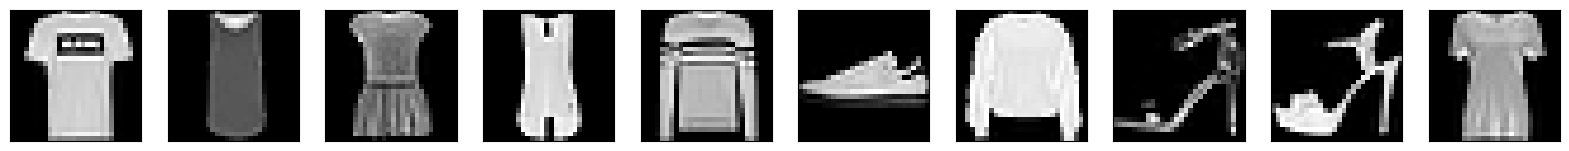

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Agora criamos um ruído aleatório e aplicamos na imagem, depois o np.clip garante que os valores não saiam do intervalo entre 0 e 1.

In [ ]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
y_train_noisy = y_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=y_train.shape)
y_test_noisy = y_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=y_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
y_train_noisy = np.clip(y_train_noisy, 0., 1.)
y_test_noisy = np.clip(y_test_noisy, 0., 1.)

Agora, verificamos se as imagens tem o ruído como esperávamos.

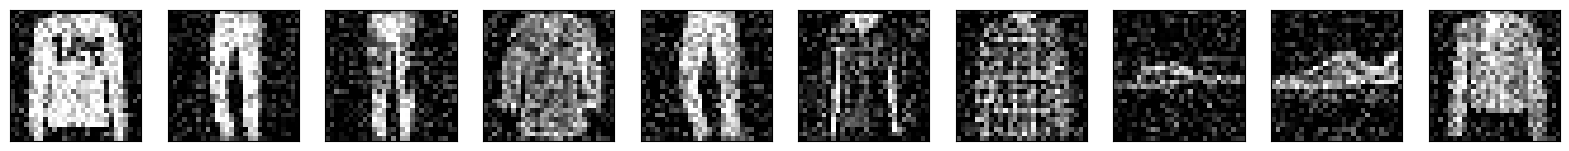

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Definição dos modelos

Começando pelo autoencoder...

In [ ]:
input_img = keras.Input(shape=(28,28,1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

A CDBNet é comumente usada para retirar ruídos de fotos reais. Tem 2 sub redes, uma para estimar a quantidade de ruído na imagem e outra para remover o ruído. Como é uma rede complexa e usada para imagens coloridas, uma alteração nas dimensões de saída foi necessária para garantir a compatibilidade com o dataset escolhido.

---

Essa implementação específica pode ser encontrada no link: https://medium.com/analytics-vidhya/image-denoising-using-deep-learning-dc2b19a3fd54

In [ ]:
input = Input(shape=(28, 28, 1))

#Noise estimation subnetwork
xx = Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(input)
xx = Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(xx)
xx = Conv2D(16, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(xx)
xx = Conv2D(3, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(xx)
xx = Conv2D(1, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(xx)

#Non Blind denoising subnetwork
xx = layers.concatenate([xx,input])
conv1 = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(xx)
conv2 = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv1)

pool1 = layers.AveragePooling2D(pool_size=(2,2),padding='same')(conv2)
conv3 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(pool1)
conv4 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv3)
conv5 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv4)

pool2 = layers.AveragePooling2D(pool_size=(2,2),padding='same')(conv5)
conv6 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(pool2)
conv7 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv6)
conv8 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv7)
conv9 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv8)
conv10 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv9)
conv11 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv10)

upsample1 = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", kernel_initializer='he_normal',padding="same")(conv11)
add1 = layers.Add()([upsample1,conv5])
conv12 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(add1)
conv13 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv12)
conv14 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv13)

upsample2 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", kernel_initializer='he_normal',padding="same")(conv14)
add1 = layers.Add()([upsample2,conv2])
conv15 = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(add1)
conv16 = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv15)

out = Conv2D(1, (1,1), kernel_initializer='he_normal',padding="same")(conv16)
out = layers.Add()([out,input])

CBDNet = Model(input,out)
CBDNet.compile(optimizer='adam', loss='binary_crossentropy')

# Treinamentos

treinamento do autoencoder por 30 épocas.

In [ ]:
history = autoencoder.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test), epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 17s 7ms/step - loss: 0.3049 - val_loss: 0.2840
Epoch 2/30
469/469 [==============================] - 4s 8ms/step - loss: 0.2779 - val_loss: 0.2776
Epoch 3/30
469/469 [==============================] - 3s 7ms/step - loss: 0.2735 - val_loss: 0.2738
Epoch 4/30
469/469 [==============================] - 3s 7ms/step - loss: 0.2705 - val_loss: 0.2717
Epoch 5/30
469/469 [==============================] - 3s 7ms/step - loss: 0.2686 - val_loss: 0.2700
Epoch 6/30
469/469 [==============================] - 4s 8ms/step - loss: 0.2674 - val_loss: 0.2690
Epoch 7/30
469/469 [==============================] - 3s 7ms/step - loss: 0.2665 - val_loss: 0.2685
Epoch 8/30
469/469 [==============================] - 3s 7ms/step - loss: 0.2658 - val_loss: 0.2676
Epoch 9/30
469/469 [==============================] - 3s 7ms/step - loss: 0.2653 - val_loss: 0.2675
Epoch 10/30
469/469 [==============================] - 3s 7ms/step - loss: 0.2648 - val_loss: 0.266

Podemos checar a evolução do treinamento com o gráfico do erro por época.

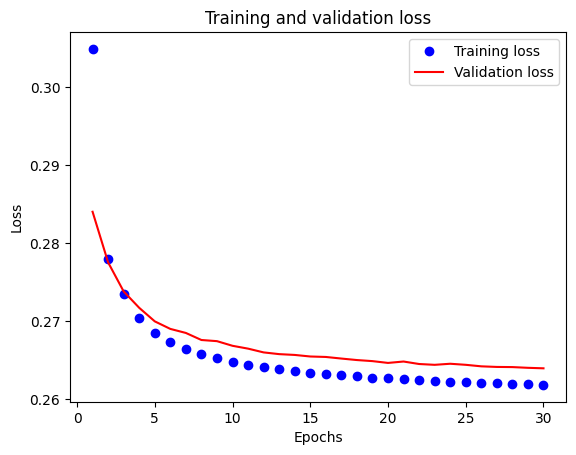

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Treinamento da CBDNet também por 30 épocas, a complexidade da rede limita a quantidade de épocas por causa dos recursos limitados para treinamento.

In [ ]:
history2 = CBDNet.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test), epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 27s 34ms/step - loss: 0.3178 - val_loss: 0.2828
Epoch 2/30
469/469 [==============================] - 15s 32ms/step - loss: 0.2824 - val_loss: 0.2886
Epoch 3/30
469/469 [==============================] - 15s 32ms/step - loss: 0.2841 - val_loss: 0.2823
Epoch 4/30
469/469 [==============================] - 16s 33ms/step - loss: 0.2758 - val_loss: 0.2750
Epoch 5/30
469/469 [==============================] - 15s 32ms/step - loss: 0.2732 - val_loss: 0.2729
Epoch 6/30
469/469 [==============================] - 15s 32ms/step - loss: 0.2707 - val_loss: 0.2713
Epoch 7/30
469/469 [==============================] - 15s 32ms/step - loss: 0.2769 - val_loss: 0.2726
Epoch 8/30
469/469 [==============================] - 15s 32ms/step - loss: 0.2719 - val_loss: 0.2858
Epoch 9/30
469/469 [==============================] - 16s 33ms/step - loss: 0.2765 - val_loss: 0.2749
Epoch 10/30
469/469 [==============================] - 15s 32ms/step - loss: 0.274

Gráfico de erro por época.

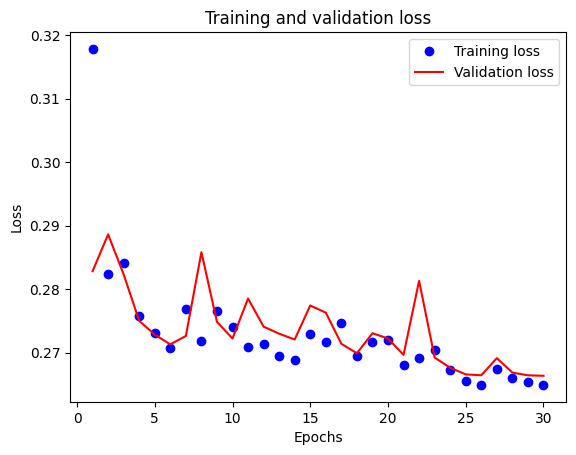

In [ ]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Predições

Finalmente, podemos comparar os resultados obtidos com ambas as redes.

In [ ]:
pred = autoencoder.predict(x_test_noisy)
pred2 = CBDNet.predict(x_test_noisy)

313/313 [==============================] - 2s 4ms/step


Fazemos o reshape das imagens para exibição

In [ ]:
x_test = np.reshape(x_test, (10000,28,28)) *255
x_test_noisy = np.reshape(x_test_noisy, (-1,28,28)) *255
pred = np.reshape(pred, (10000,28,28)) *255
pred2 = np.reshape(pred2, (10000,28,28)) *255

E agora podemos comparar os resultados da remoção do ruído visualmente.

Test Images


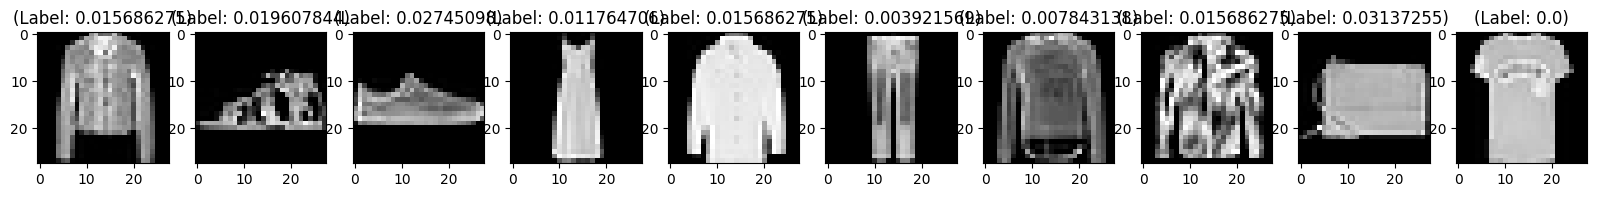

Test Images with Noise


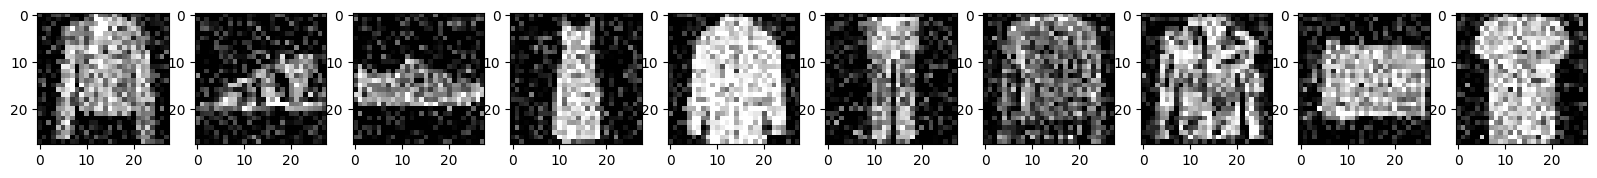

Reconstruction of Noisy Test Images with autoencoder


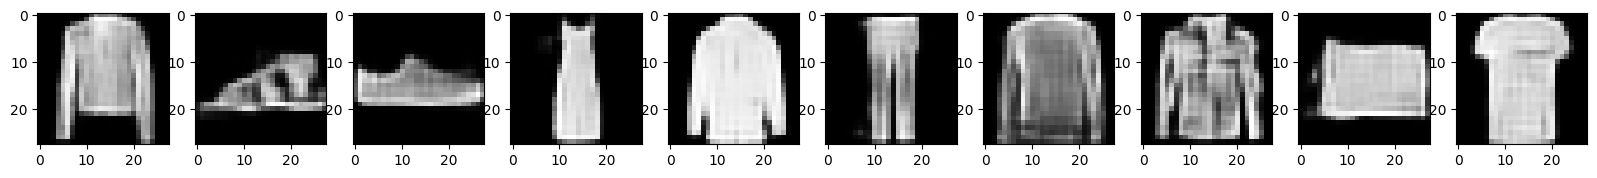

Reconstruction of Noisy Test Images with CBDNet


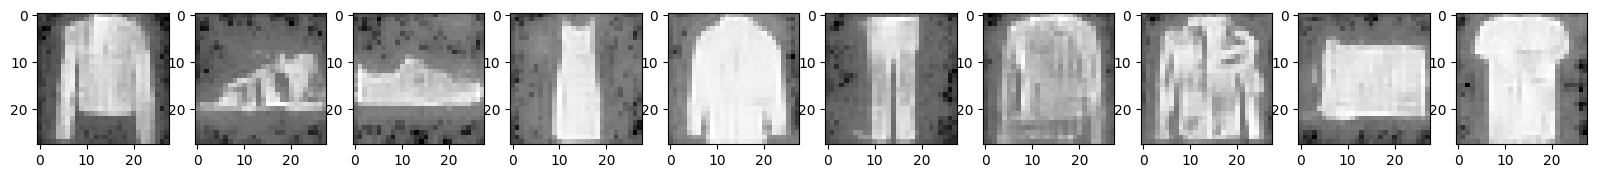

In [ ]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test[i,:,:], cmap='gray')
    curr_lbl = y_test[i]
    plt.title("(Label: " + str(curr_lbl) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Test Images with Noise")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i,:,:], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images with autoencoder")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i,:,:], cmap='gray')  
plt.show()
plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images with CBDNet")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred2[i,:,:], cmap='gray')  
plt.show()

O autoencoder parece ter tido resultados melhores, podemos confirmar isso com algumas métricas:

*   Mean Squared Error(MSE)
*   Peak Signal-to-Noise Ration (PSNR)
*   Structural Similarity Index (SSIM)
*   Mean Absolute Error (MAE)

In [ ]:
# Mean Squared Error
mse = tf.keras.losses.mean_squared_error(x_test, pred)
mse = tf.reduce_mean(mse)

# Peak Signal-to-Noise Ratio
psnr = peak_signal_noise_ratio(x_test, pred, data_range=x_test.max())

# Structural Similarity Index
ssim = structural_similarity(x_test, pred, channel_axis=True)

# Mean Absolute Error
mae = tf.keras.losses.mean_absolute_error(x_test, pred)
mae = tf.reduce_mean(mae)

# Print the values of the metrics
print("MSE:", mse.numpy())
print("PSNR:", psnr)
print("SSIM:", ssim)
print("MAE:", mae.numpy())

MSE: 403.8045
PSNR: 22.06909158776222
SSIM: 0.93512124
MAE: 10.472193


In [ ]:
# Mean Squared Error
mse = tf.keras.losses.mean_squared_error(x_test, pred2)
mse = tf.reduce_mean(mse)

# Peak Signal-to-Noise Ratio
psnr = peak_signal_noise_ratio(x_test, pred2, data_range=x_test.max())

# Structural Similarity Index
ssim = structural_similarity(x_test, pred2, channel_axis=True)

# Mean Absolute Error
mae = tf.keras.losses.mean_absolute_error(x_test, pred2)
mae = tf.reduce_mean(mae)

# Print the values of the metrics
print("MSE:", mse.numpy())
print("PSNR:", psnr)
print("SSIM:", ssim)
print("MAE:", mae.numpy())

MSE: 1645.818
PSNR: 15.966985884356653
SSIM: 0.7659264
MAE: 26.947924


#Conclusão



Os resultados mostraram que o autoencoder teve um desempenho melhor do que a CBDNet, tanto visualmente quanto nas métricas escolhidas. Uma possível explicação para isso é que o tamanho reduzido das imagens e limitação do treinamento à poucas épocas podem ter afetado negativamente o resultado da CBDNet, que é uma rede projetada para lidar com imagens coloridas e reais.